# Initialization

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")


!pip install torchsummary
!pip install thop

# Parameters
EPOCH = 50
lr = 0.01

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data transformation

In [2]:
# standard cast into Tensor and pixel values normalization in [-1, 1] range
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# data augmentation & normalization
"""
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),

    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std)
])
"""

'\ntransform_train = transforms.Compose([\n    # data augmentation\n    transforms.RandomHorizontalFlip(p=0.5),\n    transforms.RandomCrop(32, padding=4),\n\n    transforms.ToTensor(),\n    # data normalization    # standardization: (image - train_mean) / train_std\n    transforms.Normalize(mean=train_mean, std=train_std)\n])\n\ntransform_test = transforms.Compose([\n    transforms.ToTensor(),\n    # data normalization    # standardization: (image - train_mean) / train_std\n    transforms.Normalize(mean=train_mean, std=train_std)\n])\n'

# Validation split and dataloader

In [27]:
BATCH_SIZE = 16

# dataset for training and validation
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# split dataset into trainset and validset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
valid_size = 5000       # 取5000張驗證集(0.1 of dataset)
train_size = len(dataset) - valid_size
trainset, validset = random_split(dataset, [train_size, valid_size])

# dataset for testing
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True, num_workers=2)   #生成batch 
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,drop_last=True, num_workers=2)

print("train length: ", len(trainset))
print("val length: ", len(validset))
print("test length: ", len(testset))

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


# Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


# Using ResNet-like neural network
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        #[channel, hieght, width]
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        #out[8,32,32]
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True)
        )
        #out[12,32,32]
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True)
        )
        #out[20,32,32]
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        #out[32,16,16]
        self.res1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        )
        #out[32,16,16]
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        #out[48,16,16]
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        #out[64,8,8]
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        #out[128,4,4]
        self.res2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ), nn.Sequential( 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        )
        #out[128,4,4]
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), 
            nn.Flatten(), 
            nn.Linear(128, 10)
        )
        #out[10]
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res1(x) + x
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x) 
        x = self.res2(x) + x
        x = self.classifier(x)
        return x



# Parameters summary

In [5]:
from torchsummary import summary

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

net = ResNet().cuda()

grad_para = count_parameters(net)

# print(f'Total params: {grad_para / 1e6}M')
summary(net,(3,32,32))

#Compute MACs
from thop import profile

input1 = torch.randn(1,3,32,32).cuda() 
MACs, params = profile(net, inputs=(input1, ))

print('MACs = ' + str(MACs/1000**3) + 'G')

print('Params = ' + str(params/1000**2) + 'M')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 12, 32, 32]             876
       BatchNorm2d-5           [-1, 12, 32, 32]              24
              ReLU-6           [-1, 12, 32, 32]               0
            Conv2d-7           [-1, 20, 32, 32]           2,180
       BatchNorm2d-8           [-1, 20, 32, 32]              40
              ReLU-9           [-1, 20, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           5,792
      BatchNorm2d-11           [-1, 32, 32, 32]              64
             ReLU-12           [-1, 32, 32, 32]               0
        MaxPool2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

# Train

In [28]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_sch

net = ResNet().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)   # momentum-SGD，採用L2正則化（權重衰減）

"""
optimizer = optim.Adam(
          net.parameters(), 
          lr=0.001, 
          betas=(0.96, 0.9999), 
          amsgrad=True
      )
"""
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=1, epochs=EPOCH)

"""
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler
    #(Step decay)
    decay_rate = lr/(EPOCH)
    newlr = lr - decay_rate*epoch

    power = epoch // 5
    newlr = lr / pow(5, power)

    for param_group in optim.param_groups:    # change the lr to what you define
        param_group['lr'] = newlr
"""

train_loss, train_acc = [], []
val_loss, val_acc = [], []
lrs = []

for epoch in range(EPOCH):
    # train
    net.train()
    sum1_loss, sum2_loss = 0.0, 0.0
    correct = 0.0
    total = 0.0
    print('\nEpoch: %d' % (epoch + 1))
    for i, traindata in enumerate(trainloader, 0):
        # prepare data
        inputs, train_labels = traindata
        inputs, train_labels = inputs.to(device), train_labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        train_outputs = net(inputs)
        trainloss = criterion(train_outputs, train_labels)
        trainloss.backward()
        optimizer.step()

        # 每訓練1個batch的loss和acc
        sum1_loss += trainloss.item()
        _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index)
        total += train_labels.size(0)
        correct += predicted.eq(train_labels.data).cpu().sum()

    # learning rate schedule
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    #writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
    #adjust_learning_rate(optimizer, epoch)
    print("learning rate: ",  optimizer.param_groups[0]['lr'])
    
    loss1 = sum1_loss / (i + 1)
    acc1 = correct / total
    print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
    train_loss.append(loss1)
    train_acc.append(acc1.item())

    # 用val驗證
    with torch.no_grad():
        correct = 0
        total = 0
        for j, valdata in enumerate(validloader, 0):
            net.eval()
            images, val_labels = valdata
            images, val_labels = images.to(device), val_labels.to(device)
            val_outputs = net(images)
            valloss = criterion(val_outputs, val_labels)
                    
            sum2_loss += valloss.item()
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum()
                
        loss2 = sum2_loss / (j + 1)
        acc2 = correct / total
        print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
        val_loss.append(loss2)
        val_acc.append(acc2.item())


Epoch: 1
learning rate:  0.0052034602152724735
Train loss: 1.803 | Train acc: 0.352
Val loss: 1.389 | Val acc: 0.495

Epoch: 2
learning rate:  0.008753494340683884
Train loss: 1.169 | Train acc: 0.586
Val loss: 0.911 | Val acc: 0.681

Epoch: 3
learning rate:  0.014472088841534572
Train loss: 0.897 | Train acc: 0.690
Val loss: 0.817 | Val acc: 0.711

Epoch: 4
learning rate:  0.022072489510780793
Train loss: 0.809 | Train acc: 0.726
Val loss: 0.767 | Val acc: 0.731

Epoch: 5
learning rate:  0.03117358052235722
Train loss: 0.783 | Train acc: 0.735
Val loss: 0.829 | Val acc: 0.714

Epoch: 6
learning rate:  0.04131899517009691
Train loss: 0.760 | Train acc: 0.745
Val loss: 0.777 | Val acc: 0.736

Epoch: 7
learning rate:  0.052000000000000005
Train loss: 0.752 | Train acc: 0.748
Val loss: 0.911 | Val acc: 0.705

Epoch: 8
learning rate:  0.0626810048299031
Train loss: 0.742 | Train acc: 0.753
Val loss: 0.808 | Val acc: 0.734

Epoch: 9
learning rate:  0.07282641947764279
Train loss: 0.720 | T

# Test accuracy

In [31]:
# 用test測試
with torch.no_grad():
    correct = 0
    total = 0
    sum3_loss = 0.0
    for k, testdata in enumerate(testloader, 0):
        net.eval()
        imgs, test_labels = testdata
        imgs, test_labels = imgs.to(device), test_labels.to(device)
        test_outputs = net(imgs)
        testloss = criterion(test_outputs, test_labels)
                    
        sum3_loss += testloss.item()
        _, predicted = torch.max(test_outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum()
                
    loss3 = sum3_loss / (k + 1)
    acc3 = correct / total
    print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))

Test loss: 0.628 | Test acc: 0.868


# Plot

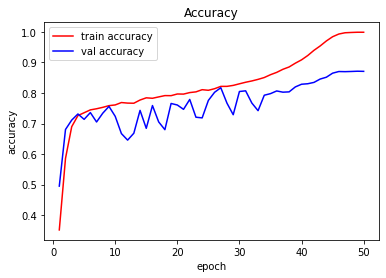

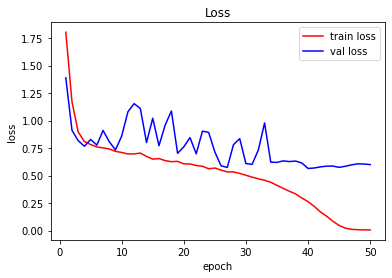

In [32]:
from matplotlib import pyplot as plt
import numpy as np
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy") 
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss") 
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()